In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from gluonts.dataset.common import ListDataset
from uni2ts.model.moirai_moe import MoiraiMoEForecast, MoiraiMoEModule
from uni2ts.eval_util.plot import plot_single

d:\Manchester\ERP\Code\AdvancedLLM\venv_units\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


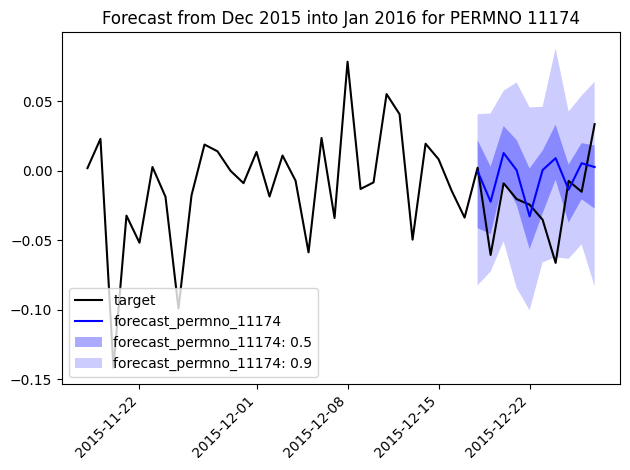

In [ ]:

# --- Load datasets ---
estimation_df = pd.read_csv("top50_estimation.csv")
outofsample_df = pd.read_csv("top50_outofsample.csv")

estimation_df["date"] = pd.to_datetime(estimation_df["date"])
outofsample_df["date"] = pd.to_datetime(outofsample_df["date"])

# --- Settings ---
permno = estimation_df["PERMNO"].iloc[0]  # choose one PERMNO
context_length = 30
prediction_length = 12
cutoff_date = pd.to_datetime("2015-12-31")

# --- Extract context window from estimation_df ---
train_df = estimation_df[
    (estimation_df["PERMNO"] == permno) &
    (estimation_df["date"] <= cutoff_date)
].sort_values("date").dropna()

context_df = train_df.tail(context_length)
context_df = context_df.set_index("date").rename(columns={"EXCESS_RET": "target"})
context_start = context_df.index[0]
context_target = context_df["target"].tolist()

# --- Create ListDataset for forecasting ---
train_ds = ListDataset(
    [{"start": context_start, "target": context_target}],
    freq="D"
)

# --- Load Moirai-MoE model ---
model = MoiraiMoEForecast(
    module=MoiraiMoEModule.from_pretrained("Salesforce/moirai-moe-1.0-R-small"),
    prediction_length=prediction_length,
    context_length=context_length,
    patch_size=16,
    num_samples=100,
    target_dim=1,
    feat_dynamic_real_dim=0,
    past_feat_dynamic_real_dim=0,
)

predictor = model.create_predictor(batch_size=16)
forecast_it = predictor.predict(train_ds)

# --- Extract forecast ---
forecast = next(forecast_it)

# --- Ground truth from out-of-sample test set ---
test_df = outofsample_df[
    outofsample_df["PERMNO"] == permno
].sort_values("date").dropna()

true_future = test_df["EXCESS_RET"].values[:prediction_length]
true_start = test_df["date"].values[0]

# --- Create label dict ---
label = {
    "target": true_future.tolist(),
    "start": pd.to_datetime(true_start)
}

# --- Plot forecast vs actual ---
test_series = list(train_ds)[0]

plot_single(
    test_series,
    label,
    forecast,
    context_length=context_length,
    name=f"forecast_permno_{permno}",
    show_label=True,
)

plt.title(f"Forecast from Dec 2015 into Jan 2016 for PERMNO {permno}")
plt.tight_layout()
plt.show()


In [18]:
avg_market_caps = (
    estimation_df.groupby('PERMNO')['MKT_CAP']
    .mean()
    .sort_values(ascending=False)
)

display((avg_market_caps))

top_n = max(1, int(len(avg_market_caps) * 0.1))

# Get top 10% PERMNOs
top_10_pct_permnos = avg_market_caps.sort_values(ascending=False).head(top_n).index.tolist()
# Get top 10% PERMNOs
min_10_pct_permnos = avg_market_caps.sort_values(ascending=True).head(top_n).index.tolist()

print("Top 10% PERMNOs by Market Cap:", top_10_pct_permnos)
print("Top 10% PERMNOs by Market Cap:", min_10_pct_permnos)

PERMNO
66093    1.525569e+11
76226    3.595558e+10
29647    2.611607e+10
78405    1.118811e+10
86339    1.055632e+10
81696    7.598825e+09
78840    7.298822e+09
80924    7.229011e+09
80089    6.775381e+09
85991    6.431542e+09
86218    6.293792e+09
68857    5.442989e+09
86996    4.300831e+09
85421    3.685955e+09
75049    3.578480e+09
83604    3.376114e+09
75104    3.168778e+09
63773    2.881172e+09
86869    2.862269e+09
75320    2.501611e+09
81043    1.828247e+09
80863    1.680567e+09
47677    1.403899e+09
87075    1.154848e+09
85425    8.716167e+08
87255    8.424249e+08
86560    8.418272e+08
66835    7.894038e+08
81740    7.215712e+08
81133    5.610599e+08
86155    5.065920e+08
80297    4.760784e+08
12173    4.420072e+08
83989    3.138813e+08
78971    3.003444e+08
87373    2.848481e+08
11174    2.269973e+08
87121    2.182236e+08
79033    2.037563e+08
87339    1.817428e+08
87342    1.671391e+08
86916    1.621737e+08
39731    5.290920e+07
Name: MKT_CAP, dtype: float64

Top 10% PERMNOs by Market Cap: [66093, 76226, 29647, 78405]
Top 10% PERMNOs by Market Cap: [39731, 86916, 87342, 87339]


In [15]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
from gluonts.dataset.common import ListDataset
from uni2ts.model.moirai_moe import MoiraiMoEForecast, MoiraiMoEModule

# --- Load data ---
estimation_df = pd.read_csv("top50_estimation.csv")
outofsample_df = pd.read_csv("top50_outofsample.csv")

estimation_df["date"] = pd.to_datetime(estimation_df["date"])
outofsample_df["date"] = pd.to_datetime(outofsample_df["date"])

# --- Forecast parameters ---
context_length = 30
prediction_length = 12
cutoff_date = pd.to_datetime("2015-12-31")

# --- Load Moirai-MoE model ---
model = MoiraiMoEForecast(
    module=MoiraiMoEModule.from_pretrained("Salesforce/moirai-moe-1.0-R-small"),
    prediction_length=prediction_length,
    context_length=context_length,
    patch_size=16,
    num_samples=100,
    target_dim=1,
    feat_dynamic_real_dim=0,
    past_feat_dynamic_real_dim=0,
)
predictor = model.create_predictor(batch_size=16)

# --- Loop through all PERMNOs ---
permnos = sorted(outofsample_df["PERMNO"].unique())
results = []

for permno in permnos:
    try:
        # Get training context (last 30 days before 2016)
        train_df = estimation_df[
            (estimation_df["PERMNO"] == permno) &
            (estimation_df["date"] <= cutoff_date)
        ].sort_values("date").dropna(subset=["EXCESS_RET"])

        if len(train_df) < context_length:
            print(f"⏩ Skipping {permno} (not enough train data)")
            continue

        context_df = train_df.tail(context_length).copy()
        context_df = context_df.set_index("date").rename(columns={"EXCESS_RET": "target"})

        train_ds = ListDataset(
            [{
                "start": context_df.index[0],
                "target": context_df["target"].tolist()
            }],
            freq="D"
        )

        # Get true future (first 12 days of 2016)
        test_df = outofsample_df[outofsample_df["PERMNO"] == permno].sort_values("date")
        test_df = test_df.dropna(subset=["EXCESS_RET"])

        if len(test_df) < prediction_length:
            print(f" Skipping {permno} (not enough test data)")
            continue

        true_target = test_df["EXCESS_RET"].values[:prediction_length]

        # Forecast
        forecast_it = predictor.predict(train_ds)
        forecast = next(forecast_it)
        predicted = forecast.samples.mean(axis=0)

        # Metrics
        r2 = r2_score(true_target, predicted)
        mse = mean_squared_error(true_target, predicted)
        directional = np.mean(np.sign(np.diff(true_target)) == np.sign(np.diff(predicted)))

        # R2 out-of-sample (relative to context mean)
        context_mean = context_df["target"].mean()
        baseline = np.full_like(true_target, context_mean)
        r2_out = 1 - np.sum((true_target - predicted)**2) / np.sum((true_target - baseline)**2)

        results.append({
            "PERMNO": permno,
            "R2": r2,
            "R2_out_of_sample": r2_out,
            "MSE": mse,
            "Directional Accuracy": directional
        })

    except Exception as e:
        print(f"Error with PERMNO {permno}: {e}")


In [16]:
# --- Output results ---
results_df_all = pd.DataFrame(results)
print("\n Forecasting Results:")
print(results_df_all.round(3))


 Forecasting Results:
    PERMNO      R2  R2_out_of_sample    MSE  Directional Accuracy
0    11174  -0.146            -0.086  0.001                 0.545
1    12173  -0.189            -0.094  0.001                 0.636
2    29647   0.009             0.029  0.000                 0.636
3    39731  -1.269            -1.032  0.002                 0.455
4    47677  -0.424            -0.163  0.001                 0.636
5    63773  -0.751            -0.324  0.001                 0.182
6    66093  -0.139            -0.137  0.000                 0.364
7    66835  -0.074            -0.074  0.000                 0.545
8    68857  -0.780            -0.746  0.000                 0.727
9    75049   0.048             0.098  0.000                 0.636
10   75104  -0.005            -0.002  0.000                 0.818
11   75320  -0.454            -0.024  0.000                 0.273
12   76226  -0.271            -0.269  0.001                 0.273
13   78405   0.172             0.198  0.000          

In [20]:

summary_all = results_df_all.drop(columns='PERMNO').mean()

# Compute top 10% and bottom 10% based on R2
top_10pct = results_df_all[results_df_all["PERMNO"].isin(top_10_pct_permnos)]
bottom_10pct = results_df_all[results_df_all["PERMNO"].isin(min_10_pct_permnos)]
summary_top = top_10pct.drop(columns='PERMNO').mean()
summary_bottom = bottom_10pct.drop(columns='PERMNO').mean()

# Combine into one table
summary = pd.DataFrame({
    "All Stocks": summary_all,
    "Top 10%": summary_top,
    "Bottom 10%": summary_bottom
})

# Transpose the table for readability
summary_transposed = summary.T.round(3)
display(summary_transposed)

,R2,R2_out_of_sample,MSE,Directional Accuracy
All Stocks,-1.208,-0.869,0.001,0.495
Top 10%,-0.057,-0.045,0.000,0.500
Bottom 10%,-1.259,-1.193,0.002,0.432


In [11]:
final_result_mean = results_df_all.drop(columns=['PERMNO']).mean().to_frame().T

final_result_mean.index = ['Uni2TS']

display(final_result_mean.round(3))

,R2,R2_out_of_sample,MSE,Directional Accuracy
Uni2TS,-1.369,-0.966,0.002,0.493


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
from gluonts.dataset.common import ListDataset
from uni2ts.model.moirai_moe import MoiraiMoEForecast, MoiraiMoEModule

# --- Load data ---
estimation_df = pd.read_csv("top50_estimation.csv")
outofsample_df = pd.read_csv("top50_outofsample.csv")

estimation_df["date"] = pd.to_datetime(estimation_df["date"])
outofsample_df["date"] = pd.to_datetime(outofsample_df["date"])

# --- Forecast parameters ---
context_length = 30
prediction_length = 12
cutoff_date = pd.to_datetime("2015-12-31")
ROLLING_WINDOWS = [5, 21, 252, 512]
TARGET = "EXCESS_RET"

# --- Load Moirai-MoE model ---
model = MoiraiMoEForecast(
    module=MoiraiMoEModule.from_pretrained("Salesforce/moirai-moe-1.0-R-small"),
    prediction_length=prediction_length,
    context_length=context_length,
    patch_size=16,
    num_samples=100,
    target_dim=1,
    feat_dynamic_real_dim=0,
    past_feat_dynamic_real_dim=0,
)
predictor = model.create_predictor(batch_size=16)

# --- Forecasting loop for each rolling window ---
results = []

for window in ROLLING_WINDOWS:
    rolling_col = f"rolling_mean_{window}"

    for permno in sorted(outofsample_df["PERMNO"].unique()):
        try:
            # --- Prepare train ---
            train_df = estimation_df[
                (estimation_df["PERMNO"] == permno) & (estimation_df["date"] <= cutoff_date)
            ].sort_values("date").dropna(subset=[TARGET, rolling_col])

            if len(train_df) < context_length:
                continue

            context_df = train_df.tail(context_length).copy()
            context_df = context_df.set_index("date").rename(columns={TARGET: "target"})

            train_ds = ListDataset(
                [{"start": context_df.index[0], "target": context_df["target"].tolist()}],
                freq="D"
            )

            # --- Prepare test ---
            test_df = outofsample_df[
                outofsample_df["PERMNO"] == permno
            ].sort_values("date").dropna(subset=[TARGET, rolling_col])

            if len(test_df) < prediction_length:
                continue

            true_target = test_df[TARGET].values[:prediction_length]

            # --- Forecast ---
            forecast_it = predictor.predict(train_ds)
            forecast = next(forecast_it)
            predicted = forecast.samples.mean(axis=0)

            # --- Metrics ---
            r2 = r2_score(true_target, predicted)
            mse = mean_squared_error(true_target, predicted)
            directional = np.mean(np.sign(np.diff(true_target)) == np.sign(np.diff(predicted)))

            context_mean = context_df["target"].mean()
            r2_out = 1 - np.sum((true_target - predicted) ** 2) / np.sum((true_target - context_mean) ** 2)

            results.append({
                "Model": "Uni2TS-MoiraiMoE",
                "Rolling Window": window,
                "PERMNO": permno,
                "R2": r2,
                "R2_out_of_sample": r2_out,
                "MSE": mse,
                "Directional Accuracy": directional
            })

        except Exception as e:
            print(f"⚠️ Skipping PERMNO {permno} (window={window}): {e}")

# --- Results to DataFrame ---
uni2ts_df = pd.DataFrame(results)
uni2ts_avg_by_window = uni2ts_df.groupby("Rolling Window")[
    ["R2", "R2_out_of_sample", "MSE", "Directional Accuracy"]
].mean().reset_index()


c:\Users\fazlu\OneDrive - The University of Manchester\Pictures\Skripsi\ERP\Code\AdvancedLLM\venv_units\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
display(uni2ts_df)
uni2ts_df.to_csv("Results/moirai-moe-1.0.csv", index=False)
display(uni2ts_avg_by_window)

,Model,Rolling Window,PERMNO,R2,R2_out_of_sample,MSE,Directional Accuracy
0,Uni2TS-MoiraiMoE,5,11174,-0.341111,-0.200899,0.001152,0.545455
1,Uni2TS-MoiraiMoE,5,12173,-0.283604,-0.239651,0.000419,0.545455
2,Uni2TS-MoiraiMoE,5,29647,-0.055095,0.051288,0.000339,0.454545
3,Uni2TS-MoiraiMoE,5,39731,-0.115213,-0.105719,0.001389,0.545455
4,Uni2TS-MoiraiMoE,5,47677,-0.305367,-0.259524,0.000870,0.272727
...,...,...,...,...,...,...,...
158,Uni2TS-MoiraiMoE,512,86996,-0.320630,-0.052210,0.000190,0.545455
159,Uni2TS-MoiraiMoE,512,87075,-0.017312,0.006405,0.000219,0.727273
160,Uni2TS-MoiraiMoE,512,87121,-1.630931,-1.481546,0.000470,0.272727
161,Uni2TS-MoiraiMoE,512,87339,-0.210794,-0.186691,0.001000,0.454545


,Rolling Window,R2,R2_out_of_sample,MSE,Directional Accuracy
0,5,-0.552320,-0.461600,0.001812,0.579281
1,21,-1.374559,-1.248997,0.002710,0.473573
2,252,-2.044435,-1.311922,0.000919,0.445455
3,512,-0.994994,-0.834322,0.000653,0.503686


In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
from gluonts.dataset.common import ListDataset
from uni2ts.model.moirai_moe import MoiraiMoEForecast, MoiraiMoEModule

# --- Load data ---
estimation_df = pd.read_csv("top50_estimation.csv")
outofsample_df = pd.read_csv("top50_outofsample.csv")

estimation_df["date"] = pd.to_datetime(estimation_df["date"])
outofsample_df["date"] = pd.to_datetime(outofsample_df["date"])

# --- Forecast parameters ---
context_length = 30
prediction_length = 12
cutoff_date = pd.to_datetime("2015-12-31")
ROLLING_WINDOWS = [5, 21, 252, 512]
TARGET = "EXCESS_RET"

# --- Load Moirai-MoE model ---
model = MoiraiMoEForecast(
    module=MoiraiMoEModule.from_pretrained("Salesforce/moirai-moe-1.0-R-base"),
    prediction_length=prediction_length,
    context_length=context_length,
    patch_size=16,
    num_samples=100,
    target_dim=1,
    feat_dynamic_real_dim=0,
    past_feat_dynamic_real_dim=0,
)
predictor = model.create_predictor(batch_size=16)

# --- Forecasting loop for each rolling window ---
results = []

for window in ROLLING_WINDOWS:
    rolling_col = f"rolling_mean_{window}"

    for permno in sorted(outofsample_df["PERMNO"].unique()):
        try:
            # --- Prepare train ---
            train_df = estimation_df[
                (estimation_df["PERMNO"] == permno) & (estimation_df["date"] <= cutoff_date)
            ].sort_values("date").dropna(subset=[TARGET, rolling_col])

            if len(train_df) < context_length:
                continue

            context_df = train_df.tail(context_length).copy()
            context_df = context_df.set_index("date").rename(columns={TARGET: "target"})

            train_ds = ListDataset(
                [{"start": context_df.index[0], "target": context_df["target"].tolist()}],
                freq="D"
            )

            # --- Prepare test ---
            test_df = outofsample_df[
                outofsample_df["PERMNO"] == permno
            ].sort_values("date").dropna(subset=[TARGET, rolling_col])

            if len(test_df) < prediction_length:
                continue

            true_target = test_df[TARGET].values[:prediction_length]

            # --- Forecast ---
            forecast_it = predictor.predict(train_ds)
            forecast = next(forecast_it)
            predicted = forecast.samples.mean(axis=0)

            # --- Metrics ---
            r2 = r2_score(true_target, predicted)
            mse = mean_squared_error(true_target, predicted)
            directional = np.mean(np.sign(np.diff(true_target)) == np.sign(np.diff(predicted)))

            context_mean = context_df["target"].mean()
            r2_out = 1 - np.sum((true_target - predicted) ** 2) / np.sum((true_target - context_mean) ** 2)

            results.append({
                "Model": "Uni2TS-MoiraiMoE",
                "Rolling Window": window,
                "PERMNO": permno,
                "R2": r2,
                "R2_out_of_sample": r2_out,
                "MSE": mse,
                "Directional Accuracy": directional
            })

        except Exception as e:
            print(f"⚠️ Skipping PERMNO {permno} (window={window}): {e}")

# --- Results to DataFrame ---
uni2ts_base_df = pd.DataFrame(results)
uni2ts_base_avg_by_window = uni2ts_df.groupby("Rolling Window")[
    ["R2", "R2_out_of_sample", "MSE", "Directional Accuracy"]
].mean().reset_index()

display(uni2ts_base_df)
uni2ts_base_df.to_csv("Results/moirai-moe-1.0-R-base.csv", index=False)
display(uni2ts_base_avg_by_window)

,Model,Rolling Window,PERMNO,R2,R2_out_of_sample,MSE,Directional Accuracy
0,Uni2TS-MoiraiMoE,5,11174,-1.744253,-1.457342,0.002357,0.363636
1,Uni2TS-MoiraiMoE,5,12173,-1.295405,-1.216806,0.000750,0.454545
2,Uni2TS-MoiraiMoE,5,29647,-0.226343,-0.102694,0.000395,0.545455
3,Uni2TS-MoiraiMoE,5,39731,-2.248583,-2.220927,0.004047,0.545455
4,Uni2TS-MoiraiMoE,5,47677,-0.026706,0.009351,0.000684,0.545455
...,...,...,...,...,...,...,...
158,Uni2TS-MoiraiMoE,512,86996,0.087149,0.272688,0.000131,0.636364
159,Uni2TS-MoiraiMoE,512,87075,-8.141413,-7.928299,0.001971,0.545455
160,Uni2TS-MoiraiMoE,512,87121,-0.115446,-0.052110,0.000199,0.363636
161,Uni2TS-MoiraiMoE,512,87339,-0.055604,-0.034590,0.000871,0.454545


,Rolling Window,R2,R2_out_of_sample,MSE,Directional Accuracy
0,5,-0.552320,-0.461600,0.001812,0.579281
1,21,-1.374559,-1.248997,0.002710,0.473573
2,252,-2.044435,-1.311922,0.000919,0.445455
3,512,-0.994994,-0.834322,0.000653,0.503686


In [5]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
from gluonts.dataset.common import ListDataset
from uni2ts.model.moirai_moe import MoiraiMoEForecast, MoiraiMoEModule

# Load data
estimation_df = pd.read_csv("top50_estimation.csv")
outofsample_df = pd.read_csv("top50_outofsample.csv")
estimation_df["date"] = pd.to_datetime(estimation_df["date"])
outofsample_df["date"] = pd.to_datetime(outofsample_df["date"])

# Forecast parameters
context_length = 5
prediction_length = 252
cutoff_date = pd.to_datetime("2015-12-31")
ROLLING_WINDOWS = [5]
TARGET = "EXCESS_RET"

# Load model
model = MoiraiMoEForecast(
    module=MoiraiMoEModule.from_pretrained("Salesforce/moirai-moe-1.0-R-base"),
    prediction_length=prediction_length,
    context_length=context_length,
    patch_size=16,
    num_samples=100,
    target_dim=1,
    feat_dynamic_real_dim=0,
    past_feat_dynamic_real_dim=0,
)
predictor = model.create_predictor(batch_size=16)

portfolio_data = []

for window in ROLLING_WINDOWS:
    rolling_col = f"rolling_mean_{window}"

    for permno in sorted(outofsample_df["PERMNO"].unique()):
        try:
            train_df = estimation_df[
                (estimation_df["PERMNO"] == permno) & (estimation_df["date"] <= cutoff_date)
            ].sort_values("date").dropna(subset=[TARGET, rolling_col])

            if len(train_df) < context_length:
                continue

            context_df = train_df.tail(context_length).copy()
            context_df = context_df.set_index("date").rename(columns={TARGET: "target"})

            train_ds = ListDataset(
                [{"start": context_df.index[0], "target": context_df["target"].tolist()}],
                freq="D"
            )

            test_df = outofsample_df[
                outofsample_df["PERMNO"] == permno
            ].sort_values("date").dropna(subset=[TARGET, rolling_col])

            if len(test_df) < prediction_length:
                continue

            true_target = test_df[TARGET].values[:prediction_length]
            forecast_dates = test_df["date"].iloc[:prediction_length].values

            forecast_it = predictor.predict(train_ds)
            forecast = next(forecast_it)
            predicted = forecast.samples.mean(axis=0)

            for i in range(prediction_length):
                portfolio_data.append({
                    "date": forecast_dates[i],
                    "PERMNO": permno,
                    "pred": predicted[i],
                    "EXCESS_RET": true_target[i]
                })

        except Exception as e:
            print(f"Error with PERMNO {permno}: {e}")
            continue

# Create DataFrame
portfolio_df = pd.DataFrame(portfolio_data)
portfolio_df['date'] = pd.to_datetime(portfolio_df['date'])


# Assign deciles
portfolio_df['rank'] = portfolio_df.groupby('date')['pred'].transform(
    lambda x: pd.qcut(x.rank(method='first'), q=4, labels=False, duplicates='drop')
)

# Long-Short daily returns
long_returns = portfolio_df[portfolio_df['rank'] == 3].groupby('date')['EXCESS_RET'].mean()
short_returns = portfolio_df[portfolio_df['rank'] == 0].groupby('date')['EXCESS_RET'].mean()
long_short = long_returns - short_returns

# With and without transaction cost
TRANSACTION_COST = 0.002
portfolio = pd.DataFrame({
    "long_ret": long_returns,
    "short_ret": short_returns,
    "long_short_ret": long_short
})
portfolio["long_short_cum"] = (1 + portfolio["long_short_ret"]).cumprod()
portfolio["long_short_ret_tc"] = portfolio["long_short_ret"] - TRANSACTION_COST * 2
portfolio["long_short_cum_tc"] = (1 + portfolio["long_short_ret_tc"]).cumprod()

# Save or display results
portfolio.to_csv("Results/uni2ts_portfolio.csv")
print(portfolio.head())



            long_ret  short_ret  long_short_ret  long_short_cum  \
date                                                              
2016-01-13 -0.012899  -0.028436        0.015537        1.015537   
2016-01-14 -0.001072   0.007525       -0.008597        1.006806   
2016-01-15 -0.022035  -0.027648        0.005614        1.012458   
2016-01-19 -0.013482  -0.001238       -0.012244        1.000061   
2016-01-20 -0.027112  -0.016077       -0.011035        0.989025   

            long_short_ret_tc  long_short_cum_tc  
date                                              
2016-01-13           0.011537           1.011537  
2016-01-14          -0.012597           0.998794  
2016-01-15           0.001614           1.000406  
2016-01-19          -0.016244           0.984155  
2016-01-20          -0.015035           0.969358  


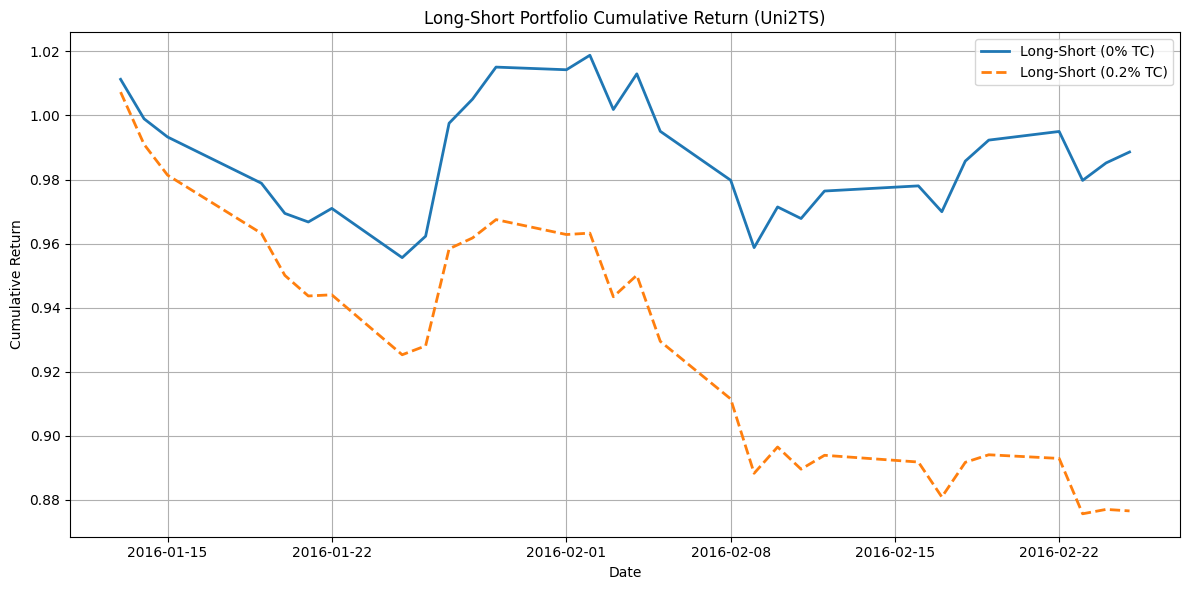

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(portfolio.index, portfolio["long_short_cum"], label="Long-Short (0% TC)", linewidth=2)
plt.plot(portfolio.index, portfolio["long_short_cum_tc"], label="Long-Short (0.2% TC)", linestyle="--", linewidth=2)

plt.title("Long-Short Portfolio Cumulative Return (Uni2TS)")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("Results/uni2ts_long_short_cumulative.png", dpi=300)
plt.show()
